<a href="https://colab.research.google.com/github/Kallol7/tensorflowProjects/blob/main/dog_breed_classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
data_folders =["test","train","valid"]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/dog_breed.zip" -d "/content"

In [ ]:
test_data_names = os.listdir("test")
train_data_names = os.listdir("train")
valid_data_names= os.listdir("valid")
assert test_data_names == train_data_names
for v_name in valid_data_names:
    if v_name not in test_data_names:
        print(v_name)
# add American  Spaniel to class_mapper

American  Spaniel


In [ ]:
class_map = {} # {class_name: index}
for indx,name in enumerate(test_data_names):
    class_map[name] = indx

# to prevent class mismatch
class_map["American  Spaniel"] = class_map["American Spaniel"]
class_map

{'Rhodesian': 0,
 'Malinois': 1,
 'Pekinese': 2,
 'Basset': 3,
 'Clumber': 4,
 'Doberman': 5,
 'Chinese Crested': 6,
 'Vizsla': 7,
 'Bichon Frise': 8,
 'African Wild Dog': 9,
 'Chow': 10,
 'Collie': 11,
 'Bulldog': 12,
 'Golden Retriever': 13,
 'Bluetick': 14,
 'Pit Bull': 15,
 'Chihuahua': 16,
 'Poodle': 17,
 'French Bulldog': 18,
 'Lhasa': 19,
 'Dhole': 20,
 'Cockapoo': 21,
 'Elk Hound': 22,
 'Coyote': 23,
 'Boston Terrier': 24,
 'Great Dane': 25,
 'Maltese': 26,
 'Groenendael': 27,
 'Border Collie': 28,
 'American Hairless': 29,
 'Bull Terrier': 30,
 'Yorkie': 31,
 'Bermaise': 32,
 'Scotch Terrier': 33,
 'Bearded Collie': 34,
 'Irish Spaniel': 35,
 'Greyhound': 36,
 'Rottweiler': 37,
 'American Spaniel': 38,
 'Shih-Tzu': 39,
 'Corgi': 40,
 'Dingo': 41,
 'Siberian Husky': 42,
 'Shar_Pei': 43,
 'Cairn': 44,
 'Labradoodle': 45,
 'Afghan': 46,
 'Pomeranian': 47,
 'Bloodhound': 48,
 'Cocker': 49,
 'Labrador': 50,
 'German Sheperd': 51,
 'Schnauzer': 52,
 'Newfoundland': 53,
 'Irish Wolfh

In [ ]:
def load_data(path,class_names,batch_size,img_size):
    class_indx = [class_map[name] for name in class_names]
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        class_names=class_names,
        color_mode="rgb",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42,
        crop_to_aspect_ratio=False
    )

def scale(x,y):
    return (x*1./255,y)

def augment_images(image, label):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ])

    return data_augmentation(image), label

def augment_and_add(train_data):
    combined_dataset = train_data
    for i in range(10):
        # Apply data augmentation to each image in the dataset
        augmented_data = train_data.map(augment_images)
        # Combine both datasets into one
        combined_dataset = tf.data.Dataset.concatenate(combined_dataset, augmented_data)
    return combined_dataset

In [ ]:
batch_size = 8000 #10000
img_size = (32,32)

train_data = load_data('train',train_data_names,batch_size,img_size)
train_data = train_data.map(scale)

Found 7946 files belonging to 70 classes.


In [ ]:
def draw_countplot(train_iter):
    all_y = []
    while True:
      batch = None
      try:
        batch = train_iter.next()
      except:
        break
      all_y.extend(batch[1])

    sns.set(style='whitegrid',rc={"figure.figsize": (20, 6)},font_scale=1)
    sns.countplot(x=all_y,dodge=True,width=.8,edgecolor="none",palette="rocket",order=pd.value_counts(all_y).index)
    plt.xlabel("Class")
    plt.show()

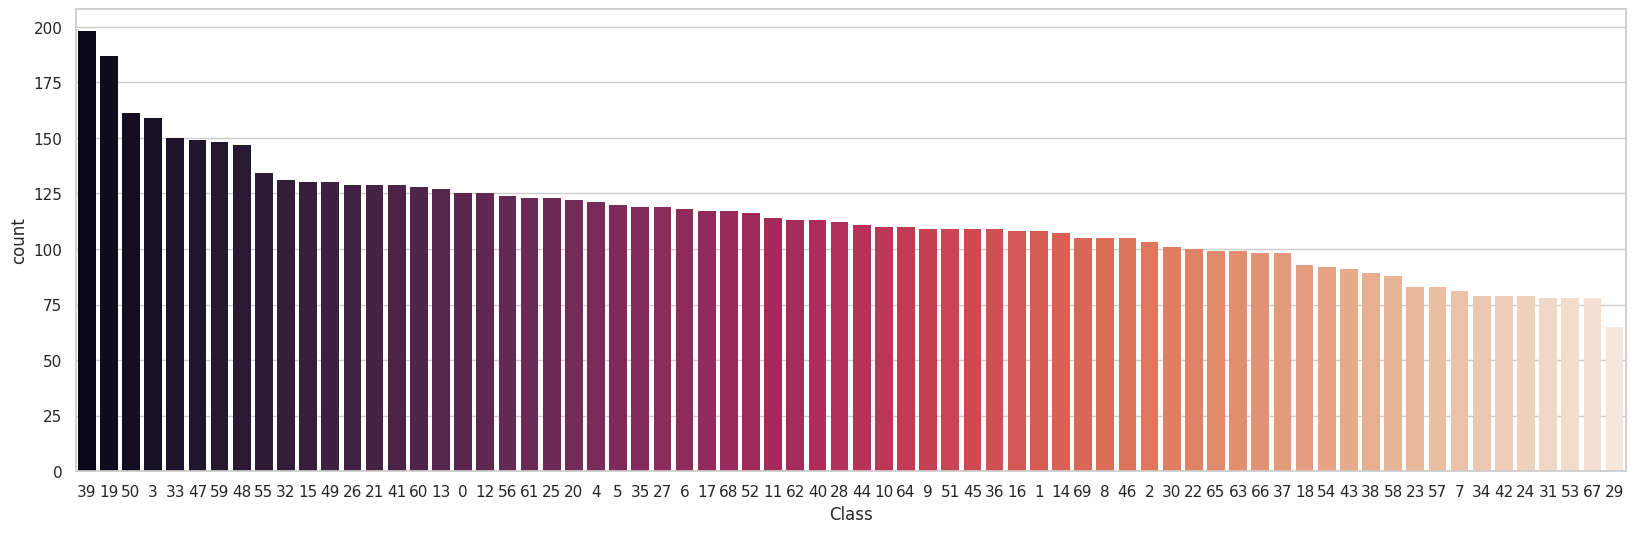

In [ ]:
# Visualize Class Imbalance
train_iter= train_data.as_numpy_iterator()
draw_countplot(train_iter)
del train_iter

In [ ]:
def apply_resampling(train_data):
    under = RandomUnderSampler(sampling_strategy="not minority")
    over = SMOTE(sampling_strategy="not majority")

    # Separate features and labels
    train_features = []
    train_labels = []
    for batch in train_data:
        train_features.append(batch[0])
        train_labels.append(batch[1])
    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)

    # Reshape the features for resampling
    train_features = np.reshape(train_features, (train_features.shape[0], -1))

    # Apply oversampling first
    train_features, train_labels = over.fit_resample(train_features, train_labels)

    # Apply undersampling
    train_features, train_labels = under.fit_resample(train_features, train_labels)

    # Reshape the features back to the original shape
    train_features = np.reshape(train_features, (train_features.shape[0], *img_size, 3))

    # Create a TensorFlow dataset from the resampled data
    final_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    final_dataset = final_dataset.shuffle(train_features.shape[0]).batch(batch_size)

    num_train_examples = train_features.shape[0]
    return final_dataset, num_train_examples

def smote_and_undersample(train_data):
    final_dataset, num_train_examples = apply_resampling(train_data)

    assert isinstance(final_dataset, tf.data.Dataset)  # Ensure final_dataset is of type tf.data.Dataset
    return final_dataset, num_train_examples

In [ ]:
train_data,num_train_examples = smote_and_undersample(train_data)
print("After resampling ", num_train_examples, "total images")

After resampling  13860 total images


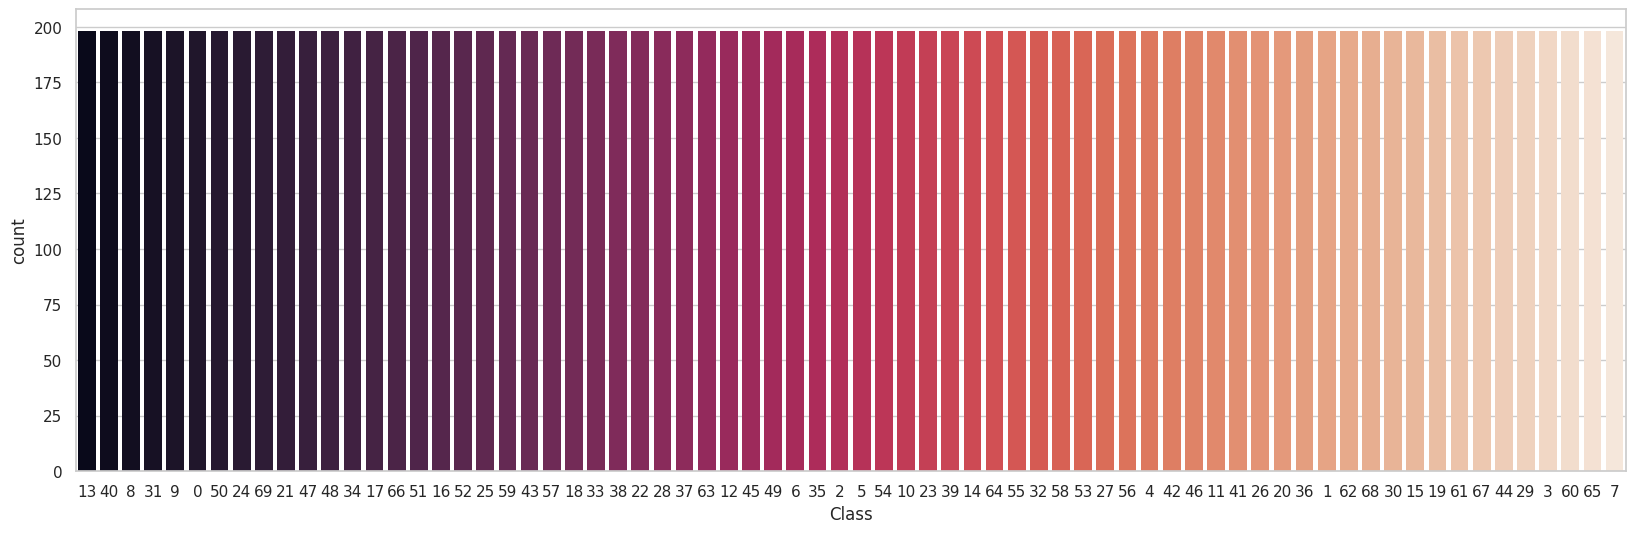

In [ ]:
# Class distribution after balancing
train_iter= train_data.as_numpy_iterator()
draw_countplot(train_iter)
del train_iter

In [ ]:
train_data = augment_and_add(train_data)

test_data = load_data('test', test_data_names,batch_size,img_size)
test_data = test_data.map(scale)

valid_data = load_data('valid', valid_data_names,batch_size,img_size)
valid_data = valid_data.map(scale)

Found 700 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [ ]:
# 10 augemted images + the original image = 11, hence num_train_examples*11
num_train_examples = num_train_examples*11
train_data = train_data.cache().repeat().shuffle(num_train_examples) # .batch(batch_size) already applied
valid_data = valid_data.cache() # .batch(batch_size) already applied
test_batch = test_data.repeat().as_numpy_iterator()

In [ ]:
### Using softmax and SparseCategoricalCrossentropy has use.
### Safter approach, use linear output(no activation on output layer)
### and use SparseCategoricalCrossentropy(from_logits=True)
def create_model(learning_rate=1e-3):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,kernel_size=(3,3),padding="same",activation=tf.nn.relu,input_shape=(*img_size,3)),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(16,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(16,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.Conv2D(12,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=75,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.64),
        tf.keras.layers.Dense(units=70)
    ])

    model.compile(optimizer= tf.optimizers.Adam(learning_rate),
                loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"]
    )
    return model

# Input will have the biggest dropout 0.8
# Use dropout on hidden layers where lots of parameters and has a chance of overfitting
# Good droupout range 0.5 to 0.8
model = create_model(1e-3)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        2

In [ ]:
def scheduler(epoch, lr):
    if epoch%80==0:
        return lr * tf.math.exp(-0.1)
    else:
        return lr

In [ ]:
#  validation_steps: Only relevant if `validation_data` is provided and
#                 is a `tf.data` dataset. Total number of steps (batches of
#                 samples) to draw before stopping when performing validation
#                 at the end of every epoch. If 'validation_steps' is None,
#                 validation will run until the `validation_data` dataset is
#                 exhausted. In the case of an infinitely repeated dataset, it
#                 will run into an infinite loop. If 'validation_steps' is
#                 specified and only part of the dataset will be consumed, the
#                 evaluation will start from the beginning of the dataset at each
#                 epoch. This ensures that the same validation samples are used
#                 every time.

In [ ]:
steps_per_epoch = tf.math.ceil(num_train_examples/batch_size)
validation_steps = tf.math.ceil(700/batch_size)
decay = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0.001,patience=300,mode="max",restore_best_weights=True)
history = model.fit(train_data,epochs=15000,validation_data=valid_data,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,callbacks=[early_stop, decay])

Epoch 1/15000
20/20 [==============================] - 100s 3s/step - loss: 4.2353 - accuracy: 0.0185 - val_loss: 4.2179 - val_accuracy: 0.0214 - lr: 9.0484e-04
Epoch 2/15000
20/20 [==============================] - 24s 1s/step - loss: 4.1368 - accuracy: 0.0342 - val_loss: 4.1366 - val_accuracy: 0.0386 - lr: 9.0484e-04
Epoch 3/15000
20/20 [==============================] - 21s 1s/step - loss: 4.0121 - accuracy: 0.0475 - val_loss: 4.0867 - val_accuracy: 0.0486 - lr: 9.0484e-04
Epoch 4/15000
20/20 [==============================] - 21s 1s/step - loss: 3.9133 - accuracy: 0.0584 - val_loss: 4.0211 - val_accuracy: 0.0671 - lr: 9.0484e-04
Epoch 5/15000
20/20 [==============================] - 22s 1s/step - loss: 3.8480 - accuracy: 0.0651 - val_loss: 4.0063 - val_accuracy: 0.0743 - lr: 9.0484e-04
Epoch 6/15000
20/20 [==============================] - 22s 1s/step - loss: 3.7697 - accuracy: 0.0752 - val_loss: 3.9719 - val_accuracy: 0.0857 - lr: 9.0484e-04
Epoch 7/15000
20/20 [==================

In [ ]:
#  remove previous checkpoint
for file in os.listdir("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/checkpoints"):
    os.remove(os.path.join("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/checkpoints",file))

#  Save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/checkpoints/first",save_format="tf")

# #  Restore the weights after compiling a new model instance
# model = model.load('/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/checkpoints/first.tf')

In [ ]:
batch= test_batch.next()
batch = batch[:16]
res = model.predict(batch[0])

fig,ax = plt.subplots(2,8,figsize=(9,3))
num = 0
for i in range(2):
    for j in range(8):
        true_label = res[num].argmax()
        predicted = batch[1][num]
        ax[i,j].imshow(batch[0][num])
        plt.rcParams.update({'font.size': 4})
        ax[i,j].set_title(f"Breed: {test_data_names[true_label]}")
        plt.rcParams.update({'font.size': 4})
        ax[i,j].set_xlabel(f"Predicted:\n{test_data_names[predicted]}")
        num+=1
fig.tight_layout(h_pad=0.6,w_pad=3)
plt.show()

In [ ]:
model.evaluate(test_data)